In [48]:
# Load in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from surprise import KNNWithMeans, NMF
from surprise import Dataset, NormalPredictor, Reader, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, root_mean_squared_error
from tqdm import tqdm
from sklearn.decomposition import NMF as NMF_

from utils import find_optimal_param

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load in dataset
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()

# Create ratings matrix
rating_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')
rating_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question 7: 

**Understanding the NMF cost function:** Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For $U$ fixed, formulate it as a least-squares problem.

[TODO]

## Question 8

**Designing the NMF Collaborative Filter**

**Part A**: Designing a NMF-based Collaborative Filter and Plotting Minimum Average RMSE and Minimum Average MAE Across Number of Latent Factors

In [140]:
# Load in data
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Define cross-validation iterator
kf = KFold(n_splits = 10)

# Number of factors for every even number between 2-50, inclusive
k_values = np.arange(2, 52, 2)

# Keep track of RMSE and MAE
rmse_values = []
mae_values = []

# Iterate over k values
for n_factors in tqdm(k_values):

    # Get RMSE and MAE values for given k
    rmse_val = []
    mae_val = []

    for trainset, testset in kf.split(data):
        # Train and test algorithm
        algo = NMF(n_factors=n_factors, verbose=False).fit(trainset)
        predictions = algo.test(testset)

        # Compute RMSE and MAE
        rmse_val.append(accuracy.rmse(predictions, verbose=False))
        mae_val.append(accuracy.mae(predictions, verbose=False))

    # Compute average RMSE and MAE
    rmse_values.append(np.mean(rmse_val))
    mae_values.append(np.mean(mae_val))

100%|██████████| 25/25 [07:16<00:00, 17.45s/it]


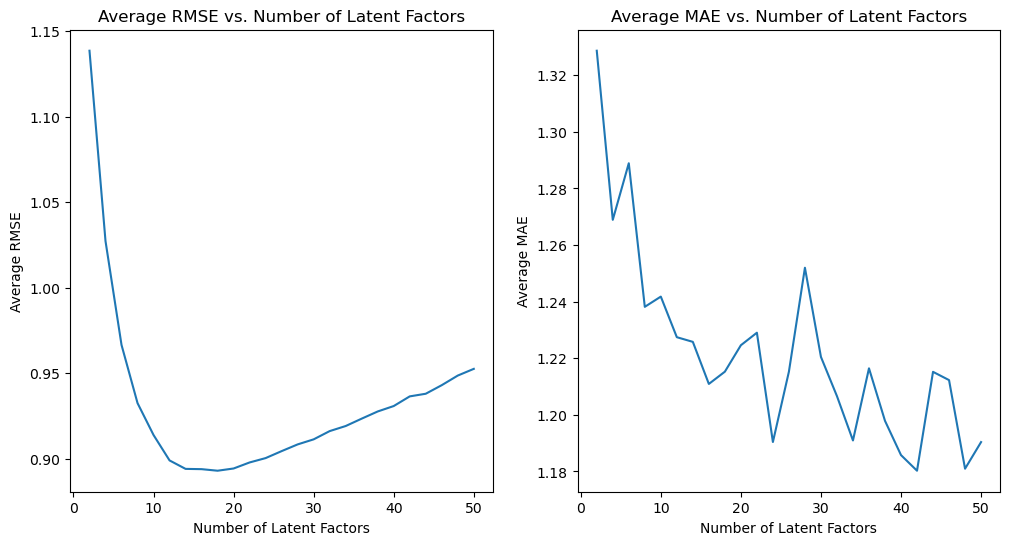

In [139]:
# Plot average RMSE vs n_factors and average MAE vs n_factors

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(k_values, rmse_values)
ax1.set_xlabel('Number of Latent Factors')
ax1.set_ylabel('Average RMSE')
ax1.set_title('Average RMSE vs. Number of Latent Factors')

ax2.plot(k_values, mae_values)
ax2.set_xlabel('Number of Latent Factors')
ax2.set_ylabel('Average MAE')
ax2.set_title('Average MAE vs. Number of Latent Factors')
plt.show()


**Part B**: Finding the Optimal Number of Latent Factors

In [141]:
print(f'Minimum RMSE of {min(rmse_values):.3f}) @ {k_values[np.argmin(rmse_values)]}')
print(f'Minimum MAE of {min(mae_values):.3f}) @ {k_values[np.argmin(mae_values)]}')

Minimum RMSE of 0.911) @ 18
Minimum MAE of 0.694) @ 22


There are 18 genres (19, including `no genres listed`) and the optimal number of latent factors (i.e. the number of latent factors that got smallest RMSE value) is 18. Excluding the `no genres listed` category, the optimal number of latent factors is indeed the same as the number of movie generes (for RMSE, that is. The minimum MAE corresponded to an optimal number of 22 latent factors, which is greater than the number of genres.)

**Part C**: Performance on Data Subsets

In [8]:
# Popular movie trimming - Keep movies with more than 2 ratings
rating_matrix_popular = rating_matrix.copy()
rating_matrix_popular = rating_matrix_popular.loc[:, rating_matrix.count() > 2]

# Unpoular movie trimming - Keep movies with 2 or fewer ratings
rating_matrix_unpopular = rating_matrix.copy()
rating_matrix_unpopular = rating_matrix_unpopular.loc[:, rating_matrix.count() <= 2]

# High variance movie trimming - Keep movies with at least 5 ratings and have variance of at least 2
rating_matrix_high_variance = rating_matrix.copy()
rating_matrix_high_variance = rating_matrix_high_variance.loc[:, (rating_matrix_high_variance.count() >= 5) & (rating_matrix_high_variance.var() >= 2)]

# Print final shapes
print("Original shape: ", rating_matrix.shape)
print("Final shape of popular movie matrix: ", rating_matrix_popular.shape)
print("Final shape of unpopular movie matrix: ", rating_matrix_unpopular.shape)
print("Final shape of high variance movie matrix: ", rating_matrix_high_variance.shape)

# Get movieId values
popular_movies = rating_matrix_popular.columns
unpopular_movies = rating_matrix_unpopular.columns
high_variance_movies = rating_matrix_high_variance.columns

# Filter df based on movieId values
df_popular = ratings_df[ratings_df['movieId'].isin(popular_movies)]
df_unpopular = ratings_df[ratings_df['movieId'].isin(unpopular_movies)]
df_high_variance = ratings_df[ratings_df['movieId'].isin(high_variance_movies)]

Original shape:  (610, 9724)
Final shape of popular movie matrix:  (610, 4980)
Final shape of unpopular movie matrix:  (610, 4744)
Final shape of high variance movie matrix:  (610, 88)


100%|██████████| 25/25 [08:11<00:00, 19.64s/it]


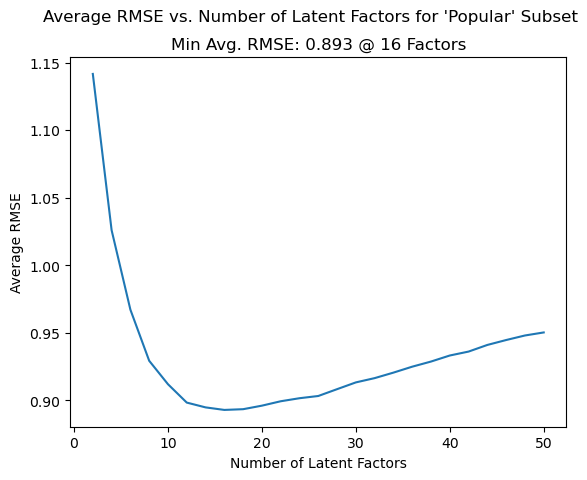

100%|██████████| 25/25 [02:23<00:00,  5.74s/it]


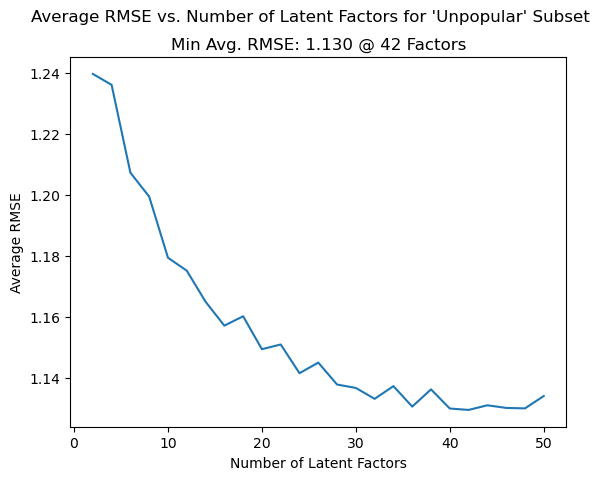

100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


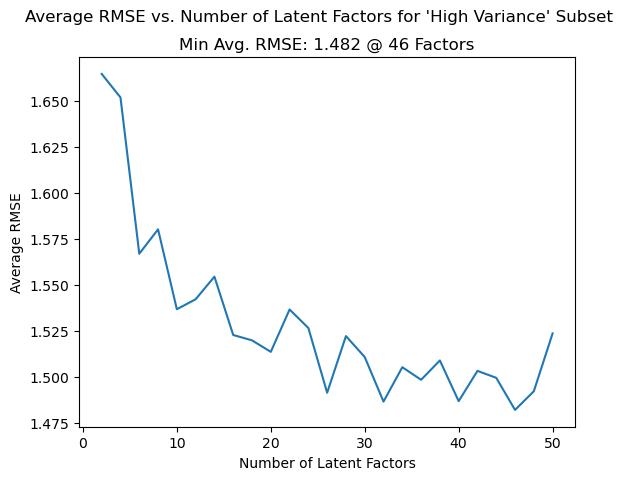

In [97]:
# Initialize datasets
dataset_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
dataset_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
dataset_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
subsets = [
    ('Popular', dataset_popular), 
    ('Unpopular', dataset_unpopular), 
    ('High Variance', dataset_high_variance)
]


for data_name, data in subsets:
    # Define cross-validation iterator
    kf = KFold(n_splits=10)

    # Number of factors for every even number between 2-50, inclusive
    k_values = np.arange(2, 52, 2)

    # Keep track of RMSE and MAE
    rmse_values = []

    # Iterate over n_factors
    for n_factors in tqdm(k_values):

        # Get RMSE and MAE values for given k
        rmse_val = []

        for trainset, testset in kf.split(data):
            # Train and test algorithm
            # Initialize NMF
            algo = NMF(n_factors=n_factors, verbose=False).fit(trainset)
            predictions = algo.test(testset)

            # Compute RMSE and MAE
            rmse_val.append(accuracy.rmse(predictions, verbose=False))

        # Compute average RMSE and MAE
        rmse_values.append(np.mean(rmse_val))

    plt.plot(k_values, rmse_values)
    plt.xlabel('Number of Latent Factors')
    plt.ylabel('Average RMSE')
    plt.suptitle(f'Average RMSE vs. Number of Latent Factors for \'{data_name}\' Subset')
    plt.title(f'Min Avg. RMSE: {min(rmse_values):.3f} @ {k_values[np.argmin(rmse_values)]} Factors')
    plt.show()


**Part D**: Plot ROC Curves

Text(0, 0.5, 'True Positive Rate')

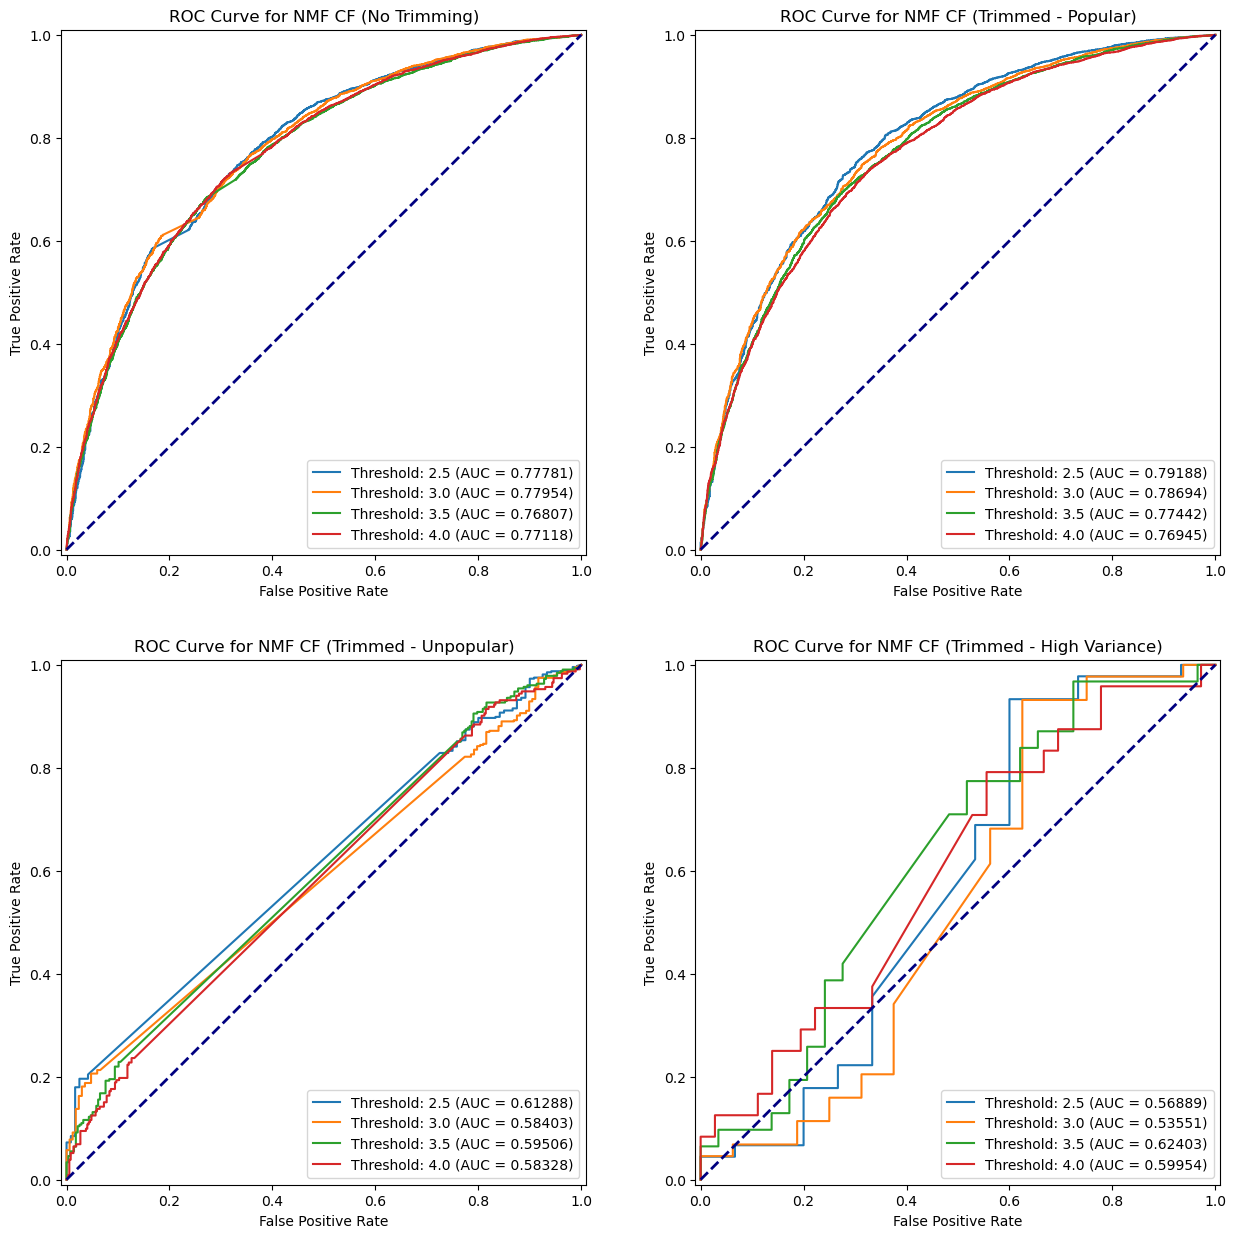

In [167]:
thresh_values = [2.5, 3.0, 3.5, 4.0]
datasets = [
    ('No Trimming', NMF(n_factors=18, verbose=False), ratings_df),
    ('Trimmed - Popular', NMF(n_factors=18, verbose=False), df_popular),
    ('Trimmed - Unpopular', NMF(n_factors=50, verbose=False), df_unpopular),
    ('Trimmed - High Variance', NMF(n_factors=42, verbose=False), df_high_variance)
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

axes_flat = axes.flatten()

for ax_i, (name, model, df) in enumerate(datasets):
    ax = axes_flat[ax_i]
    # Load in data
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.1)

    nmf_model = model.fit(trainset)
    predictions = nmf_model.test(testset)
    
    for thresh in thresh_values:
        y_true = [1 if pred.r_ui >= thresh else 0 for pred in predictions]
        y_pred = [pred.est for pred in predictions]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"Threshold: {thresh} (AUC = {auc_score:.5f})").plot(ax)

    # Plot the random chance line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Add Subplot Titles
    ax.set_title(f'ROC Curve for NMF CF ({name})')

# Set the title and labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


## Question 9

**Interpreting the NMF model**: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V, sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

Based on the results below, there appears to be a loose connection between latent factors that represent movies and movie genres. For example, the first few factors group Comedy, Drama, and Romance together. As you progress through the factors, there appears to be a shift towards Adventure, Action, and Thriller in factors 5-10. Each factor column seems to group a specific combination of genres that are closely related to each other. 

In [96]:
# Retrieve genres for all movies
movies_df = pd.read_csv('movies.csv')
genres_in_order = movies_df['genres'].tolist() # Element i contains genre of movie i

# Fit NMF Model with n_factors=20
dataset = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
trainset, testset = train_test_split(dataset, test_size=0.1)
nmf_model = NMF(n_factors=20, verbose=False)
nmf_model.fit(trainset)

# Extract factor matrices for items
V = nmf_model.qi

for col_num in range(20):
    V_col = V[:, col_num]
    top_10_item_indices = np.argsort(V_col)[::-1][:10]
    print(f'------------ Top Genres from V Column {col_num} ------------')
    for i, item_index in enumerate(top_10_item_indices):
        print(f'{i+1}. {genres_in_order[item_index]}')

------------ Top Genres from V Column 0 ------------
1. Comedy|Horror
2. Comedy|Drama
3. Drama
4. Comedy|Drama
5. Comedy
6. Comedy|Drama|Romance
7. Comedy
8. Action|Sci-Fi|Thriller
9. Action|Adventure|Drama|Romance|Thriller
10. Animation|Children|Comedy
------------ Top Genres from V Column 1 ------------
1. Comedy|Crime
2. Drama|Mystery
3. Adventure|Animation|Children|Sci-Fi|IMAX
4. Comedy|Drama|Romance
5. Comedy|Romance
6. Action|Comedy|Romance
7. Drama
8. Drama|Romance
9. Action|Drama
10. Drama|Thriller
------------ Top Genres from V Column 2 ------------
1. Crime|Thriller
2. Action|Adventure|Comedy
3. Drama
4. Action|Horror|Mystery|Sci-Fi
5. Romance|Thriller
6. Children|Drama
7. Drama|Musical
8. Drama|Western
9. Comedy
10. Animation|Children
------------ Top Genres from V Column 3 ------------
1. Action|Adventure|Drama|Fantasy|Thriller
2. Action
3. Comedy|Drama|Romance
4. Comedy|Horror
5. Drama
6. Comedy
7. Comedy|Romance
8. Action|Fantasy|Thriller
9. Crime|Horror|Mystery|Thriller


## Question 10

**Designing the MF Colalborative Filter**

**Part A**: Designing a MF-based CF and plotting average RMSE & average MAE against number of latent factors

In [ ]:
# Load in data
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))

# Define cross-validation iterator
kf = KFold(n_splits = 10)

# Number of factors for every even number between 2-50, inclusive
k_values = np.arange(2, 52, 2)

# Keep track of RMSE and MAE
rmse_values = []
mae_values = []

# Iterate over k values
for n_factors in tqdm(k_values):

    # Get RMSE and MAE values for given k
    rmse_val = []
    mae_val = []

    for trainset, testset in kf.split(data):
        # Train and test algorithm
        algo = NMF(n_factors=n_factors, biased=True, verbose=False).fit(trainset)
        predictions = algo.test(testset)

        # Compute RMSE and MAE
        rmse_val.append(accuracy.rmse(predictions, verbose=False))
        mae_val.append(accuracy.mae(predictions, verbose=False))

    # Compute average RMSE and MAE
    rmse_values.append(np.mean(rmse_val))
    mae_values.append(np.mean(mae_val))

100%|██████████| 25/25 [10:13<00:00, 24.55s/it]


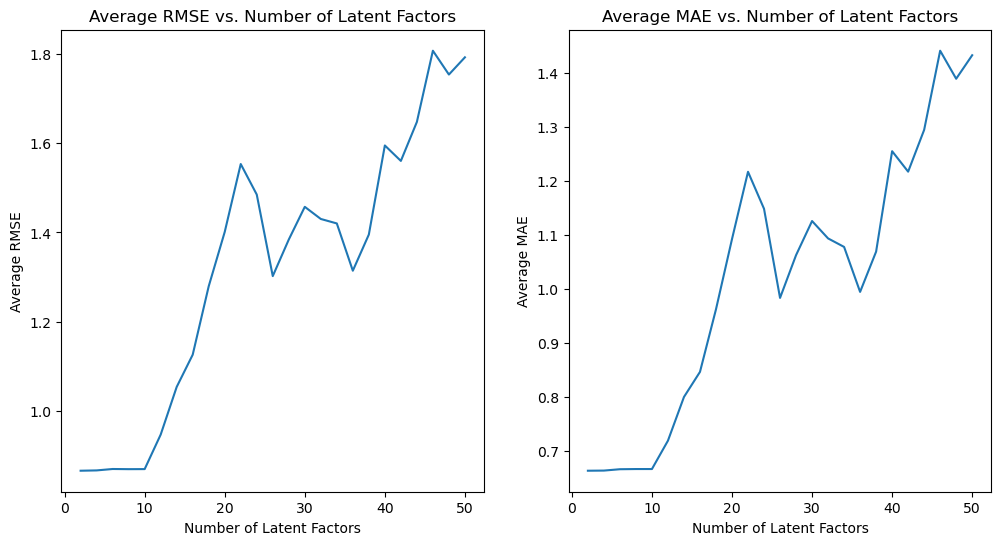

In [9]:
# Plot average RMSE vs n_factors and average MAE vs n_factors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(k_values, rmse_values)
ax1.set_xlabel('Number of Latent Factors')
ax1.set_ylabel('Average RMSE')
ax1.set_title('Average RMSE vs. Number of Latent Factors')

ax2.plot(k_values, mae_values)
ax2.set_xlabel('Number of Latent Factors')
ax2.set_ylabel('Average MAE')
ax2.set_title('Average MAE vs. Number of Latent Factors')
plt.show()

**Part B**: Finding the optimal number of latent factors.

In [10]:
print(f'Minimum RMSE of {min(rmse_values):.3f}) @ {k_values[np.argmin(rmse_values)]}')
print(f'Minimum MAE of {min(mae_values):.3f}) @ {k_values[np.argmin(mae_values)]}')

Minimum RMSE of 0.867) @ 2
Minimum MAE of 0.664) @ 2


No, the optimal number of latent factors is not the same as the number of movie genres. For both average RMSE and average MAE, the minimums corresponded with only two latent factors. This is vastly different from the number of optimal latent factors by using a NMF model with no bias. This is due to the addition of the bias terms to the optimization problem. As we introduce more latent factors, we can expect the model to capture more latent information between the the movies and what movies the users liked. At some point, too much latent information can result in overfitting, increasing our error.

**Part C**: Performance on Data Subsets

100%|██████████| 25/25 [08:20<00:00, 20.03s/it]


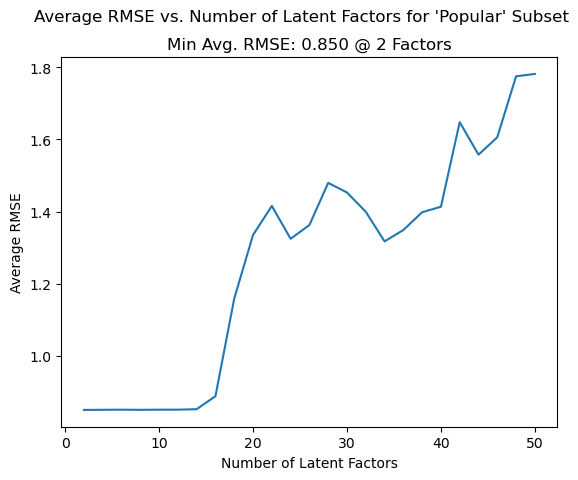

100%|██████████| 25/25 [02:21<00:00,  5.66s/it]


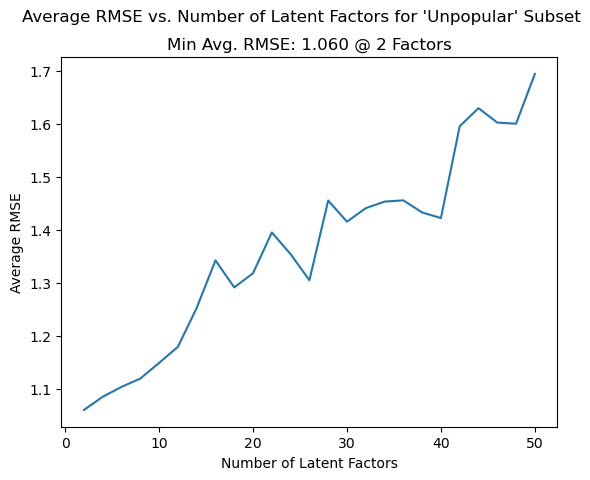

100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


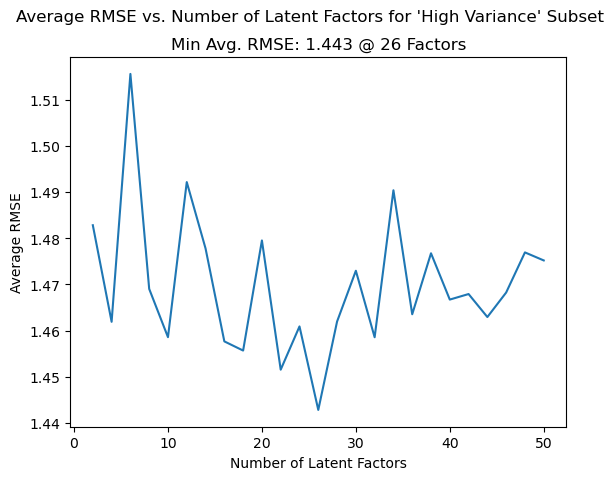

In [15]:
# Initialize datasets
dataset_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
dataset_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
dataset_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
subsets = [
    ('Popular', dataset_popular), 
    ('Unpopular', dataset_unpopular), 
    ('High Variance', dataset_high_variance)
]


for data_name, data in subsets:
    # Define cross-validation iterator
    kf = KFold(n_splits=10)

    # Number of factors for every even number between 2-50, inclusive
    k_values = np.arange(2, 52, 2)

    # Keep track of RMSE and MAE
    rmse_values = []

    # Iterate over n_factors
    for n_factors in tqdm(k_values):

        # Get RMSE and MAE values for given k
        rmse_val = []

        for trainset, testset in kf.split(data):
            # Train and test algorithm
            # Initialize NMF
            algo = NMF(n_factors=n_factors, biased=True, verbose=False).fit(trainset)
            predictions = algo.test(testset)

            # Compute RMSE and MAE
            rmse_val.append(accuracy.rmse(predictions, verbose=False))

        # Compute average RMSE and MAE
        rmse_values.append(np.mean(rmse_val))

    plt.plot(k_values, rmse_values)
    plt.xlabel('Number of Latent Factors')
    plt.ylabel('Average RMSE')
    plt.suptitle(f'Average RMSE vs. Number of Latent Factors for \'{data_name}\' Subset')
    plt.title(f'Min Avg. RMSE: {min(rmse_values):.3f} @ {k_values[np.argmin(rmse_values)]} Factors')
    plt.show()


**Part D:** Plot ROC Curves 

Text(0, 0.5, 'True Positive Rate')

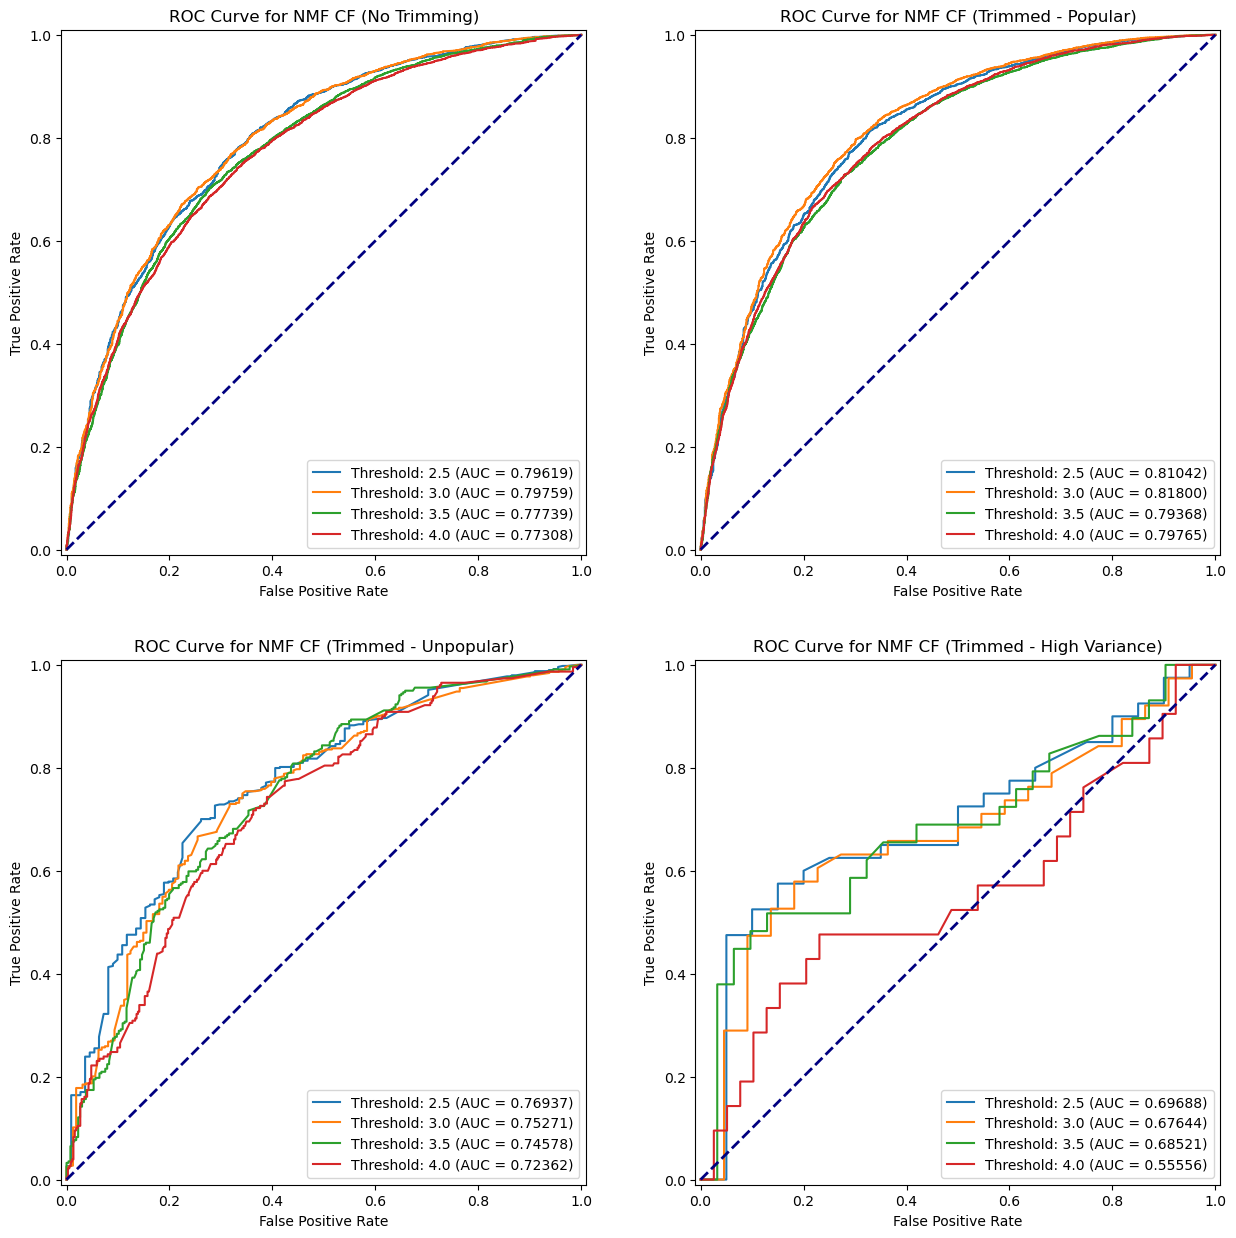

In [17]:
thresh_values = [2.5, 3.0, 3.5, 4.0]
datasets = [
    ('No Trimming', NMF(n_factors=2, biased=True, verbose=False), ratings_df),
    ('Trimmed - Popular', NMF(n_factors=2, biased=True, verbose=False), df_popular),
    ('Trimmed - Unpopular', NMF(n_factors=2, biased=True, verbose=False), df_unpopular),
    ('Trimmed - High Variance', NMF(n_factors=26, biased=True, verbose=False), df_high_variance)
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

axes_flat = axes.flatten()

for ax_i, (name, model, df) in enumerate(datasets):
    ax = axes_flat[ax_i]
    # Load in data
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
    trainset, testset = train_test_split(data, test_size=0.1)

    nmf_model = model.fit(trainset)
    predictions = nmf_model.test(testset)
    
    for thresh in thresh_values:
        y_true = [1 if pred.r_ui >= thresh else 0 for pred in predictions]
        y_pred = [pred.est for pred in predictions]
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"Threshold: {thresh} (AUC = {auc_score:.5f})").plot(ax)

    # Plot the random chance line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Add Subplot Titles
    ax.set_title(f'ROC Curve for NMF CF ({name})')

# Set the title and labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


## Question 11

**Designing a Naive Collaborative Filter**

**Part A**: Designing a Naive CF and computing average RMSE

In [63]:
# Load in data
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))

# Extract average ratings from all users
ratings_by_user = {}
for (uid, _, rating, _) in data.raw_ratings:
    if uid not in ratings_by_user.keys():
        ratings_by_user[uid] = [rating]
    else:
        ratings_by_user[uid] += [rating]
user_avg_ratings = {uid: np.mean(ratings) for uid, ratings in ratings_by_user.items()}

# Define cross-validation iterator
kf = KFold(n_splits = 10)

# Keep track of RMSE
rmse_values = []

for _, testset in kf.split(data):
    # Retrieve average rating for user
    y_pred = [user_avg_ratings[uid] for (uid, _, _) in testset]
    y_true = [rating for (_, _, rating) in testset]

    # Train and test algorithm
    rmse_values += [root_mean_squared_error(y_true, y_pred)]

# Compute average RMSE and MAE
print(f'Average RMSE of Naive CF: {np.mean(rmse_values)}')

Average RMSE of Naive CF: 0.9346886762040774


**Part B**: Performance on Dataset Subsets

In [61]:
# Using subsets from earlier
# Initialize datasets
dataset_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
dataset_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
dataset_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
subsets = [
    ('Popular', dataset_popular), 
    ('Unpopular', dataset_unpopular), 
    ('High Variance', dataset_high_variance)
]

for data_name, data in subsets:
    # Extract average ratings from all users
    ratings_by_user = {}
    for (uid, _, rating, _) in data.raw_ratings:
        if uid not in ratings_by_user.keys():
            ratings_by_user[uid] = [rating]
        else:
            ratings_by_user[uid] += [rating]
    user_avg_ratings = {uid: np.mean(ratings) for uid, ratings in ratings_by_user.items()}

    # Define cross-validation iterator
    kf = KFold(n_splits=10)

    # Keep track of RMSE
    rmse_values = []

    for _, testset in kf.split(data):
        # Retrieve average rating for user
        y_pred = [user_avg_ratings[uid] for (uid, _, _) in testset]
        y_true = [rating for (_, _, rating) in testset]

        # Train and test algorithm
        rmse_values += [root_mean_squared_error(y_true, y_pred)]

    # Compute average RMSE and MAE
    print(f'Average RMSE of Naive CF for \'{data_name}\' Subset: {np.mean(rmse_values)}')

Average RMSE of Naive CF for 'Popular' Subset: 0.9307853208794039
Average RMSE of Naive CF for 'Unpopular' Subset: 0.8408154123035223
Average RMSE of Naive CF for 'High Variance' Subset: 0.9197630948713418


## Question 12

**Comparing the most performant models across architecture**

From the ROC curve below, the Matrix Factorization with Bias Colaborative Filter model performed the best out of the three models with an AUC of 0.806. Both the k-NN and NMF collaborative filters performed similarly, with an AUC of 0.781 and 0.779, respectively. However, the k-NN CF model performed slightly better than the NMF CF model.

Text(0, 0.5, 'True Positive Rate')

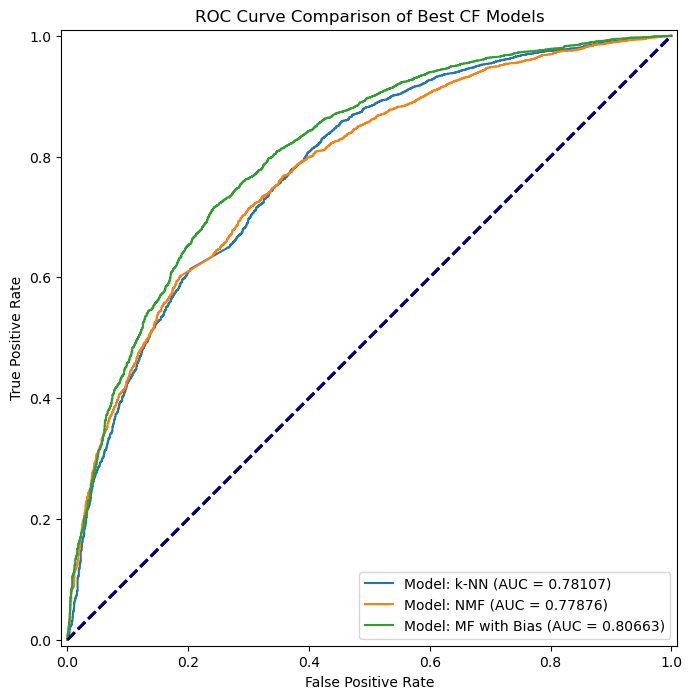

In [65]:
datasets = [
    ('k-NN', KNNWithMeans(26, sim_options={"name" : "pearson"}, verbose=False)), # kNN
    ('NMF', NMF(n_factors=18, biased=False, verbose=False)), # NMF
    ('MF with Bias', NMF(n_factors=2, biased=True, verbose=False)), # MF
]

fig, ax = plt.subplots(figsize=(8,8))

axes_flat = axes.flatten()

for name, model in datasets:
    # Load in data
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
    trainset, testset = train_test_split(data, test_size=0.1)

    nmf_model = model.fit(trainset)
    predictions = nmf_model.test(testset)
    
    y_true = [1 if pred.r_ui >= 3 else 0 for pred in predictions]
    y_pred = [pred.est for pred in predictions]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"Model: {name} (AUC = {auc_score:.5f})").plot(ax)

    # Plot the random chance line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Add Subplot Titles
    ax.set_title(f'ROC Curve Comparison of Best CF Models')

# Set the title and labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
